In [1]:
import tensorflow as tf
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
os.makedirs('../models/tflite', exist_ok=True)

In [3]:
print("\nLoading trained model...")
model = tf.keras.models.load_model('../models/finetuned/best_model.h5')

with open('../models/finetuned/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("✓ Model loaded successfully!")
model.summary()



Loading trained model...

✓ Model loaded successfully!
Model: "audio_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                            

In [4]:
# Load embeddings for quantization calibration
embeddings = np.load('../data/embeddings/embeddings.npy')

def representative_dataset_gen():
    """Generator for quantization calibration"""
    num_calibration_samples = min(100, len(embeddings))
    for i in range(num_calibration_samples):
        sample = embeddings[i:i+1].astype(np.float32)
        yield [sample]

print(f"Using {min(100, len(embeddings))} samples for quantization calibration")

Using 97 samples for quantization calibration


In [5]:
converter_float32 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float32.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_float32 = converter_float32.convert()

# Save float32 model
float32_path = '../models/tflite/audio_classifier_float32.tflite'
with open(float32_path, 'wb') as f:
    f.write(tflite_model_float32)

print(f"✓ Float32 model saved: {float32_path}")
print(f"  Size: {len(tflite_model_float32) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmpb41v9wda\assets


INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmpb41v9wda\assets


✓ Float32 model saved: ../models/tflite/audio_classifier_float32.tflite
  Size: 302.11 KB


In [6]:
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]

tflite_model_float16 = converter_float16.convert()

# Save float16 model
float16_path = '../models/tflite/audio_classifier_float16.tflite'
with open(float16_path, 'wb') as f:
    f.write(tflite_model_float16)

print(f"✓ Float16 model saved: {float16_path}")
print(f"  Size: {len(tflite_model_float16) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmp25v_wcdt\assets


INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmp25v_wcdt\assets


✓ Float16 model saved: ../models/tflite/audio_classifier_float16.tflite
  Size: 598.16 KB


In [7]:
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset_gen
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.float32
converter_int8.inference_output_type = tf.float32

tflite_model_int8 = converter_int8.convert()

# Save int8 model
int8_path = '../models/tflite/audio_classifier_int8.tflite'
with open(int8_path, 'wb') as f:
    f.write(tflite_model_int8)

print(f"✓ Int8 model saved: {int8_path}")
print(f"  Size: {len(tflite_model_int8) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmpshdyleh2\assets


INFO:tensorflow:Assets written to: C:\Users\arsht\AppData\Local\Temp\tmpshdyleh2\assets
c:\Users\arsht\Downloads\audio_classifier\venv311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✓ Int8 model saved: ../models/tflite/audio_classifier_int8.tflite
  Size: 302.02 KB



Original Keras model: 3628.55 KB
TFLite Float32: 302.11 KB (8.3% of original)
TFLite Float16: 598.16 KB (16.5% of original)
TFLite Int8: 302.02 KB (8.3% of original)


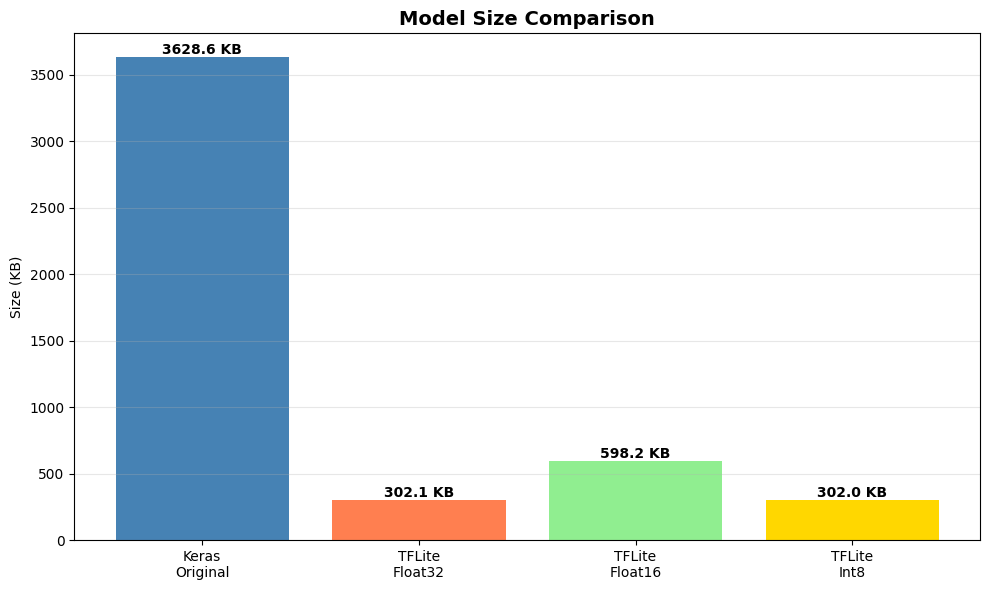

In [8]:
original_size = os.path.getsize('../models/finetuned/best_model.h5') / 1024
float32_size = len(tflite_model_float32) / 1024
float16_size = len(tflite_model_float16) / 1024
int8_size = len(tflite_model_int8) / 1024

print(f"\nOriginal Keras model: {original_size:.2f} KB")
print(f"TFLite Float32: {float32_size:.2f} KB ({float32_size/original_size*100:.1f}% of original)")
print(f"TFLite Float16: {float16_size:.2f} KB ({float16_size/original_size*100:.1f}% of original)")
print(f"TFLite Int8: {int8_size:.2f} KB ({int8_size/original_size*100:.1f}% of original)")

# Visualize size comparison
models = ['Keras\nOriginal', 'TFLite\nFloat32', 'TFLite\nFloat16', 'TFLite\nInt8']
sizes = [original_size, float32_size, float16_size, int8_size]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, sizes, color=['steelblue', 'coral', 'lightgreen', 'gold'])
plt.title('Model Size Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Size (KB)')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:.1f} KB',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Load test data
labels = np.load('../data/embeddings/labels.npy')
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    embeddings, labels, test_size=0.15, random_state=42, stratify=labels
)

def evaluate_tflite_model(tflite_model, X_test, y_test, model_name):
    """Evaluate TFLite model accuracy"""
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    correct = 0
    total = len(X_test)
    
    for i in range(total):
        input_data = X_test[i:i+1].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output_data)
        
        if pred == y_test[i]:
            correct += 1
    
    accuracy = correct / total
    print(f"{model_name}: {accuracy*100:.2f}% ({correct}/{total})")
    return accuracy

print("\nEvaluating models on test set...")
acc_float32 = evaluate_tflite_model(tflite_model_float32, X_test, y_test, "Float32")
acc_float16 = evaluate_tflite_model(tflite_model_float16, X_test, y_test, "Float16")
acc_int8 = evaluate_tflite_model(tflite_model_int8, X_test, y_test, "Int8")


Evaluating models on test set...
Float32: 46.67% (7/15)
Float16: 46.67% (7/15)
Int8: 46.67% (7/15)



Benchmarking inference speed...

Keras Original: 67.40 ± 17.39 ms
TFLite Float32: 0.06 ± 0.24 ms (speedup: 1115.28x)
TFLite Float16: 0.02 ± 0.14 ms (speedup: 3359.88x)
TFLite Int8: 0.01 ± 0.10 ms (speedup: 6608.23x)


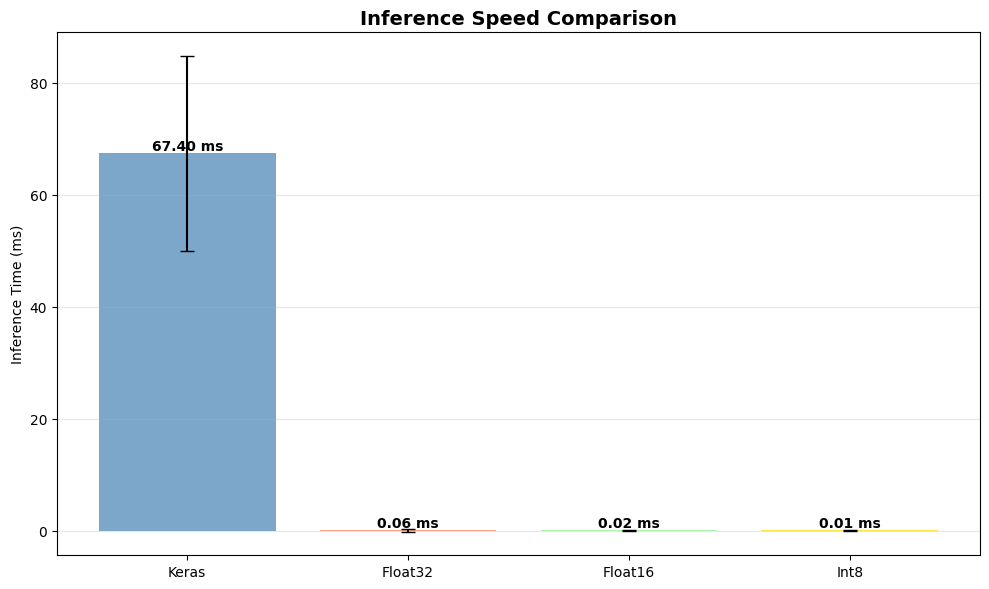

In [10]:
import time

def benchmark_tflite_model(tflite_model, X_test, num_trials=100):
    """Benchmark TFLite model inference speed"""
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    times = []
    for _ in range(num_trials):
        idx = np.random.randint(0, len(X_test))
        input_data = X_test[idx:idx+1].astype(np.float32)
        
        start = time.time()
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
        end = time.time()
        
        times.append((end - start) * 1000)  # ms
    
    return np.mean(times), np.std(times)

print("\nBenchmarking inference speed...")

# Keras model
keras_times = []
for _ in range(100):
    idx = np.random.randint(0, len(X_test))
    sample = X_test[idx:idx+1]
    start = time.time()
    _ = model.predict(sample, verbose=0)
    end = time.time()
    keras_times.append((end - start) * 1000)

keras_mean = np.mean(keras_times)
keras_std = np.std(keras_times)

float32_mean, float32_std = benchmark_tflite_model(tflite_model_float32, X_test)
float16_mean, float16_std = benchmark_tflite_model(tflite_model_float16, X_test)
int8_mean, int8_std = benchmark_tflite_model(tflite_model_int8, X_test)

print(f"\nKeras Original: {keras_mean:.2f} ± {keras_std:.2f} ms")
print(f"TFLite Float32: {float32_mean:.2f} ± {float32_std:.2f} ms (speedup: {keras_mean/float32_mean:.2f}x)")
print(f"TFLite Float16: {float16_mean:.2f} ± {float16_std:.2f} ms (speedup: {keras_mean/float16_mean:.2f}x)")
print(f"TFLite Int8: {int8_mean:.2f} ± {int8_std:.2f} ms (speedup: {keras_mean/int8_mean:.2f}x)")

# Visualize speed comparison
models = ['Keras', 'Float32', 'Float16', 'Int8']
means = [keras_mean, float32_mean, float16_mean, int8_mean]
stds = [keras_std, float32_std, float16_std, int8_std]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, means, yerr=stds, capsize=5, 
               color=['steelblue', 'coral', 'lightgreen', 'gold'], alpha=0.7)
plt.title('Inference Speed Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Inference Time (ms)')
plt.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.2f} ms',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

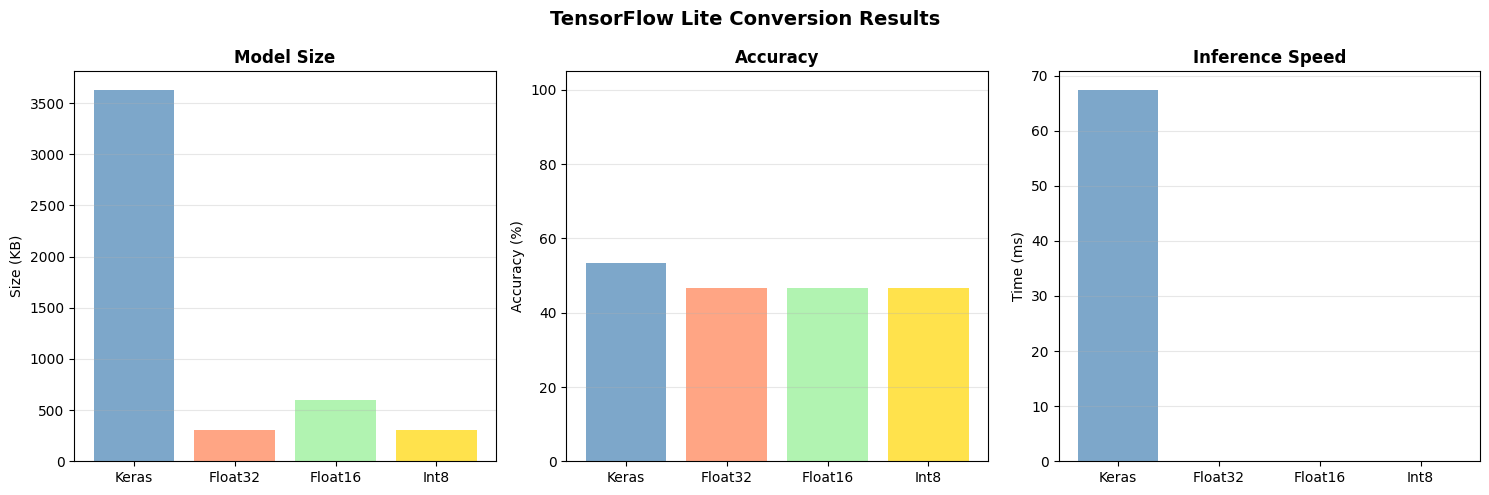

In [11]:
comparison_data = {
    'models': ['Keras', 'Float32', 'Float16', 'Int8'],
    'size_kb': [original_size, float32_size, float16_size, int8_size],
    'accuracy': [metadata['test_accuracy']*100, acc_float32*100, acc_float16*100, acc_int8*100],
    'inference_ms': [keras_mean, float32_mean, float16_mean, int8_mean]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Size
axes[0].bar(comparison_data['models'], comparison_data['size_kb'], 
            color=['steelblue', 'coral', 'lightgreen', 'gold'], alpha=0.7)
axes[0].set_title('Model Size', fontweight='bold')
axes[0].set_ylabel('Size (KB)')
axes[0].grid(True, alpha=0.3, axis='y')

# Accuracy
axes[1].bar(comparison_data['models'], comparison_data['accuracy'], 
            color=['steelblue', 'coral', 'lightgreen', 'gold'], alpha=0.7)
axes[1].set_title('Accuracy', fontweight='bold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_ylim(0, 105)
axes[1].grid(True, alpha=0.3, axis='y')

# Inference time
axes[2].bar(comparison_data['models'], comparison_data['inference_ms'], 
            color=['steelblue', 'coral', 'lightgreen', 'gold'], alpha=0.7)
axes[2].set_title('Inference Speed', fontweight='bold')
axes[2].set_ylabel('Time (ms)')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('TensorFlow Lite Conversion Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
conversion_metadata = {
    'original_model': '../models/finetuned/best_model.h5',
    'tflite_models': {
        'float32': {
            'path': float32_path,
            'size_kb': float(float32_size),
            'accuracy': float(acc_float32),
            'inference_time_ms': float(float32_mean)
        },
        'float16': {
            'path': float16_path,
            'size_kb': float(float16_size),
            'accuracy': float(acc_float16),
            'inference_time_ms': float(float16_mean)
        },
        'int8': {
            'path': int8_path,
            'size_kb': float(int8_size),
            'accuracy': float(acc_int8),
            'inference_time_ms': float(int8_mean)
        }
    },
    'class_names': metadata['class_names']
}

with open('../models/tflite/conversion_metadata.json', 'w') as f:
    json.dump(conversion_metadata, f, indent=2)

print("\n" + "="*60)
print("TFLITE CONVERSION COMPLETE!")
print("="*60)
print("\nGenerated models:")
print(f"  1. Float32: {float32_size:.2f} KB, {acc_float32*100:.2f}% accuracy")
print(f"  2. Float16: {float16_size:.2f} KB, {acc_float16*100:.2f}% accuracy")
print(f"  3. Int8: {int8_size:.2f} KB, {acc_int8*100:.2f}% accuracy")
print("\nRecommendation:")
if int8_size < 100 and acc_int8 > 0.9:
    print("  → Use Int8 model for best size/speed tradeoff")
elif acc_float16 > acc_int8 + 0.02:
    print("  → Use Float16 model for better accuracy")
else:
    print("  → Use Float32 model for maximum accuracy")


TFLITE CONVERSION COMPLETE!

Generated models:
  1. Float32: 302.11 KB, 46.67% accuracy
  2. Float16: 598.16 KB, 46.67% accuracy
  3. Int8: 302.02 KB, 46.67% accuracy

Recommendation:
  → Use Float32 model for maximum accuracy
